In [1]:
import sys
from pathlib import Path

from torch.utils.benchmark import timer

from loss import cross_entropy

ROOT_DIR = Path('..') / '..'
!pip install -q -r {ROOT_DIR/ 'requirements.txt'}

import random
import torch

from devices import Device
from matplotlib import pyplot
from numpy import loadtxt, ndarray
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import loss

from activations import relu, sigmoid, celu
from datasets import RandomUniformDataset
from networks import FeedForwardNetwork
from optimizers import StochasticGradientDescent
from utils import DATA_PATH

# Neural Networks

Neural networks, often referred to as artificial neural networks (ANNs), are computational systems that attempt to mimic the way the human brain processes information. Inspired by biological neural structures, ANNs are central to deep learning, a subset of machine learning. Over the past decade, they've driven many AI advancements, setting benchmark performance in tasks like image recognition, natural language processing, and game-playing strategies.

## Structure

A neural network is usually built with several layers of interconnected nodes or "neurons". Every connection has a weight that's adjusted during training. The primary layers of a neural network include:

1. **Input Layer:** Accepts input features and sends them to the next layer.
2. **Hidden Layers:** Intermediate layers that handle input data by processing them through weighted connections and activation functions.
3. **Output Layer:** Yields the ultimate predictions or categorizations.

Activation functions introduce non-linearity when applied by neurons to their inputs. This non-linearity is crucial as it enables the network to capture complex patterns and relationships in the data.

In this notebook, we will employ a straightforward feed-forward neural network to categorize images from the MNIST dataset. This network boasts two hidden layers with 16 units each, using the ReLU activation function. The output layer consists of 10 units, each representing a class, and applies the softmax activation function. After training the network, its parameters were saved. We will now load them to visualize a few sample predictions.

## Feed-Forward Network

Feed-forward neural networks are a category of ANNs where the units don't form cyclical connections. This ensures the data flows only in a single direction—starting from the input nodes, moving through any hidden nodes, and culminating at the output nodes. These networks lack the feedback loops that would reintroduce the model's outputs back into itself, differentiating feed-forward networks from recurrent neural networks. They focus on distinct data hierarchies, unlike convolutional networks that prioritize spatial hierarchies, or RNNs which are designed for sequences and possess a form of memory.

### MNIST Dataset Overview

The MNIST dataset comprises 70,000 grayscale images of handwritten digits. Specifically:

- **Image Dimensions**: Each image measures 28x28 pixels.
- **Pixel Representation**: Pixels range from 0 (black) to 255 (white).
- **Dataset Split**:
  - **Training Set**: 60,000 images
  - **Test Set**: 10,000 images

Due to its simplicity and established benchmarks, MNIST is a popular choice for introductory machine learning exercises, often likened to the "Hello, World!" of machine learning.

### Loading and Visualizing the MNIST Dataset

Let's load the dataset and randomly visualize some of the handwritten digits:

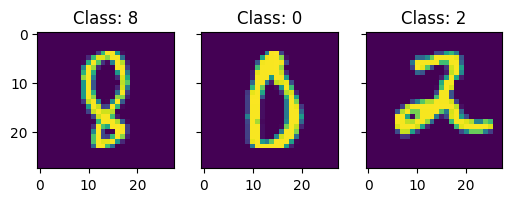

In [2]:
# Load the MNIST dataset
DATASET = MNIST(
    str(DATA_PATH / "mnist"), train=False, transform=ToTensor(), download=True
)

# Define the number of examples to visualize
N_EXAMPLES = 3


def setup_figure() -> ndarray[pyplot.Axes]:
    """Set up a figure for visualization"""
    fig = pyplot.figure(figsize=(6, N_EXAMPLES * 3))
    grid_spec = fig.add_gridspec(1, 3, hspace=2)
    axs = grid_spec.subplots(sharey='row')
    return axs


def display_examples(*axs: pyplot.Axes):
    """Display a few examples from the MNIST dataset"""
    for i in range(N_EXAMPLES):
        idx = random.randint(0, len(DATASET))
        img, label = DATASET[idx]
        view = img.view(28, 28).numpy()
        axs[i].set_title(f"Class: {label}")
        axs[i].imshow(view)


display_examples(*setup_figure())

### Using a Pre-Trained Model

#### Loading Model Parameters from Disk

In a neural network, parameters constitute the weights and biases between units. They're essential because they are learned and adjusted during the training phase, allowing the model to make accurate predictions or classifications.

For our task, we've previously trained a model on the MNIST dataset and saved its parameters to disk. Let's load these parameters and initialize our neural network model for further predictions.

In [3]:
# Load weights and biases for hidden layers
weights = [torch.from_numpy(loadtxt(DATA_PATH / f"W{i}.txt")).float() for i in (1, 2)]
biases = [torch.from_numpy(loadtxt(DATA_PATH / f"b{i}.txt")).float() for i in (1, 2)]

# Load weights and biases for the output layer
output_weights = torch.from_numpy(loadtxt(DATA_PATH / "U.txt")).float()
output_biases = torch.from_numpy(loadtxt(DATA_PATH / "c.txt")).float()

# Initialize the neural network model
MNIST_MODEL = FeedForwardNetwork(
    n_features=784,
    hidden_layer_sizes=[16, 16],
    activation_functions=[relu, relu],
    n_classes=10,
)

# Inject the loaded parameters into the model
MNIST_MODEL.load_parameters(weights, output_weights, biases, output_biases)

# Display the initialized model
print(MNIST_MODEL)

_FeedForwardNetwork__weights.0:	Parameter containing:
tensor([[-0.0434, -0.0277,  0.0810,  ...,  0.0464,  0.0212, -0.0093],
        [ 0.0317, -0.0156,  0.0085,  ..., -0.0685, -0.0469,  0.0793],
        [-0.0363,  0.0138, -0.0749,  ..., -0.0296, -0.0842,  0.0034],
        ...,
        [ 0.0076, -0.0711, -0.0182,  ...,  0.0188, -0.0464, -0.0825],
        [ 0.0712, -0.0772, -0.0423,  ...,  0.0752,  0.0765, -0.0456],
        [-0.0221, -0.0771,  0.0210,  ..., -0.0062,  0.0802,  0.0674]],
       requires_grad=True)
_FeedForwardNetwork__weights.1:	Parameter containing:
tensor([[-1.9646e-01,  2.1604e-02,  1.6983e-01, -9.0206e-02,  9.3856e-02,
         -1.7801e-01,  1.0716e-01,  5.2494e-01,  1.7323e-01, -4.1204e-01,
          3.7815e-01,  3.5523e-01,  2.1409e-01, -3.1517e-01,  1.7885e-01,
         -1.4568e-01],
        [ 3.7529e-01, -2.4033e-01,  4.6833e-01,  1.9242e-01, -2.6720e-01,
          1.8632e-01,  2.5866e-01,  1.5350e-01,  1.1219e-01,  2.4492e-01,
          4.2878e-02,  2.0355e-01, -2.

#### Making Predictions with the Model

After successfully loading the model and dataset, it's time to use our model to make predictions. We'll select a subset of images from the MNIST dataset at random and visualize their true and predicted class labels.

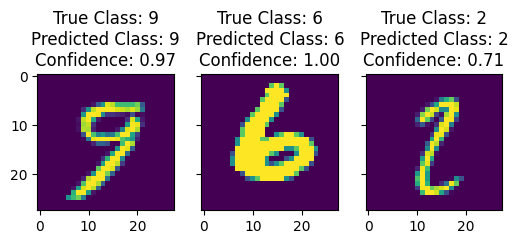

In [4]:
def display_predictions(*axs: pyplot.Axes) -> None:
    """
    Visualize predictions for a subset of the MNIST dataset.

    This function randomly selects images from the MNIST dataset, makes predictions using
    the loaded model, and visualizes the images alongside their true and predicted class labels.

    :param axs: A list of Axes objects to display the images and predictions.
    """
    for i in range(N_EXAMPLES):
        idx = random.randint(0, len(DATASET))
        img, true_label = DATASET[idx]
        img_view = img.view(28, 28).numpy()

        # Predicting the class label using the model
        pred_prob, pred_label = torch.max(MNIST_MODEL(img.view(1, 784)), dim=1)

        # Displaying the image along with true and predicted labels
        axs[i].imshow(img_view)
        axs[i].set_title(
            f"True Class: {true_label}\n"
            f"Predicted Class: {pred_label.item()}\n"
            f"Confidence: {pred_prob.item():.2f}"
        )


# Using the function to display predictions
display_predictions(*setup_figure())

#### Evaluating Model Performance

We want to see how well our model does on all the pictures we have. We'll use a function that goes through all the images in small groups, makes guesses with our model, and then counts how many guesses are right. In the end, we'll see what percentage of the guesses were correct.

In [5]:
# No es necesario que entregues código en esta parte dado 
# que solo es necesario para debuggear que tu implementación está correcta.
# Pero si quieres, igual hay espacio ;-)

epsilon = 1e-6

with torch.no_grad():
    N, F, C = 100, 300, 10
    model = FeedForwardNetwork(F, [100, 200], [sigmoid, relu], C)
    params = list(model.parameters())
    x = torch.randn(N, F)
    y = torch.zeros(N, C)
    targets = torch.randint(0, C, (N,))
    y[torch.arange(N), targets] = 1

    for i in range(len(params)):
        params[i] -= epsilon
        y_pred = model(x)
        loss1 = cross_entropy(y_pred, y)
        print(f'\nloss1: {loss1}')

        params[i] += 2 * epsilon
        y_pred = model(x)
        loss2 = cross_entropy(y_pred, y)
        print(f'loss1: {loss2}')

        appgrad = (loss2 - loss1) / 2 * epsilon
        print(f'appgrad: {appgrad}')

        params[i] -= epsilon
        y_pred = model(x)
        model.backward(x, y, y_pred)
        print(f'diff: {abs(appgrad - params[i].grad.mean())}')
        # print('grad after backward:', params[i].grad)


loss1: 1.60990309715271
loss1: 1.60990309715271
appgrad: 0.0
diff: 0.0005208067013882101

loss1: 1.6099032163619995
loss1: 1.6099029779434204
appgrad: -1.1920928924980673e-13
diff: 0.03014838881790638

loss1: 1.60990309715271
loss1: 1.60990309715271
appgrad: 0.0
diff: 4.768371808516747e-10

loss1: 1.60990309715271
loss1: 1.60990309715271
appgrad: 0.0
diff: 0.037704695016145706

loss1: 1.60990309715271
loss1: 1.60990309715271
appgrad: 0.0
diff: 0.06127149239182472

loss1: 1.6099032163619995
loss1: 1.6099032163619995
appgrad: 0.0
diff: 2.9802322831784522e-09


### Training a Neural Network with Backpropagation

Backpropagation is like a teacher for neural networks. It helps the network learn from mistakes by making small changes to its internal settings. Here's how it works:

1. **Learning from Examples:** We show the network many examples and tell it the correct answers.
2. **Making Guesses:** The network tries to guess the answer for each example.
3. **Checking Mistakes:** After guessing, we check how far off its guess was from the correct answer.
4. **Learning from Mistakes:** Using the mistakes it made, the network fine-tunes its internal settings to guess better next time.
5. **Repeat:** We keep showing examples until the network gets good at guessing right.

The magic of backpropagation is in step 4, where it figures out which settings to tweak and by how much. This "tweaking" is done using a math trick called gradient descent.

#### Checking if Gradients are Correct: Gradient Checking

Imagine you've got a math formula, and you've made some changes to it. You'd want to double-check if your changes were right. That's what gradient checking does for neural networks.

In simple terms, gradient checking compares two methods of finding gradients (slopes). One method uses the standard backpropagation technique. The other uses a quick-and-dirty method called "finite difference approximation." If both methods give similar answers, we can be pretty sure our backpropagation is set up correctly.

Here's a simple way to do gradient checking:

In [6]:
def check_gradients(epsilon: float = 1e-6):
    # Disable tracking computations
    with torch.no_grad():
        # Set some basics and random data
        samples = 100
        input_size = 300
        output_classes = 10

        # Set up a basic neural network
        model = FeedForwardNetwork(input_size, [100, 200], [sigmoid, relu], output_classes)
        parameters = list(model.parameters())

        # Random input
        input_data = torch.randn(samples, input_size)

        # Make random target labels
        labels = torch.zeros(samples, output_classes)
        targets = torch.randint(0, output_classes, (samples,))
        labels[torch.arange(samples), targets] = 1

        for param in parameters:
            # Check the loss when we reduce the parameter a tiny bit
            param -= epsilon
            pred_minus = model(input_data)
            loss_minus = loss.cross_entropy(pred_minus, labels)

            # Check the loss when we increase the parameter a tiny bit
            param += 2 * epsilon
            pred_plus = model(input_data)
            loss_plus = loss.cross_entropy(pred_plus, labels)

            # Quick-and-dirty gradient calculation
            estimated_gradient = (loss_plus - loss_minus) / (2 * epsilon)

            # Bring parameter back to original
            param -= epsilon

            # Get the actual gradient using backpropagation
            pred = model(input_data)
            model.backward(input_data, labels, pred)

            # See how different the two gradients are
            difference = torch.abs(estimated_gradient - torch.mean(param.grad))
            print(f"Difference between estimated and real gradient: {difference}")


# Run our gradient check
check_gradients()

Difference between estimated and real gradient: 0.29879987239837646
Difference between estimated and real gradient: 0.9952932596206665
Difference between estimated and real gradient: 1.907348723406699e-09
Difference between estimated and real gradient: 0.0657358467578888
Difference between estimated and real gradient: 0.08229721337556839
Difference between estimated and real gradient: 8.940697071579962e-09


#### Training the Model

Now that we've verified that our gradients are correct, we can train our model. We'll use a RandomDataset. This dataset generates random data and labels on the fly. It's useful for testing and debugging.

In [7]:
def plot_loss_and_accuracy(losses: list[float], accuracies: list[float]):
    """Plot the loss and accuracy of the model during training"""
    fig, axs = pyplot.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(losses)
    axs[0].set_title("Loss")
    axs[0].set_xlabel("Epoch")
    axs[1].plot(accuracies)
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel("Epoch")
    pyplot.show()

Epoch:100 Acc:100.00% Loss:0.0000 Tiempo/epoch:0.196s

C:\Users\Ignacio\AppData\Local\Temp\ipykernel_3028\511168794.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f1.show()
C:\Users\Ignacio\AppData\Local\Temp\ipykernel_3028\511168794.py:68: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f2.show()


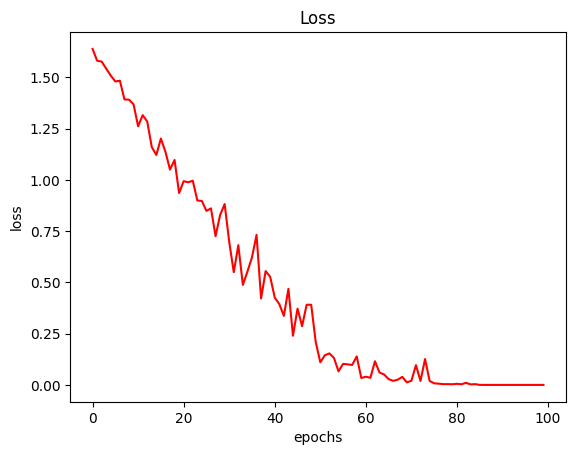

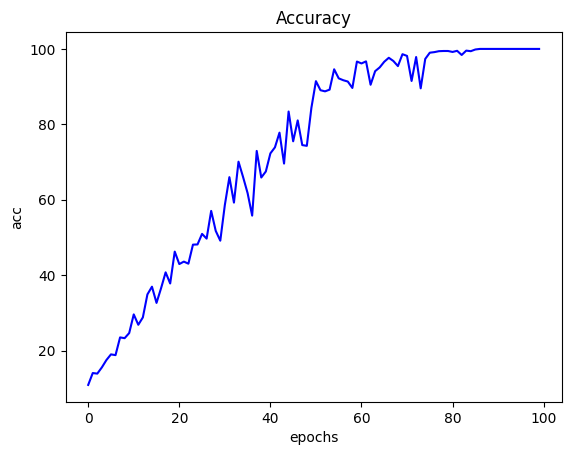

In [8]:
def train_feed_forward_network(
        red, dataset, optimizador, epochs=1, batch_size=1, reports_every=1, device=Device.CPU
):
    red.to(device)
    data = DataLoader(dataset, batch_size, shuffle=True)
    total = len(dataset)
    tiempo_epochs = 0
    loss, acc = [], []
    for e in range(1, epochs + 1):
        inicio_epoch = timer()

        for x, y in data:
            x, y = x.view(x.size(0), -1).float().to(device), y.to(device)

            y_pred = red(x)

            y_onehot = torch.zeros_like(y_pred)
            y_onehot[torch.arange(x.size(0)), y] = 1.0

            red.backward(x, y_onehot, y_pred)

            optimizador.step()

        tiempo_epochs += timer() - inicio_epoch

        if e % reports_every == 0:
            X = dataset.data.view(len(dataset), -1).float().to(device)
            Y = dataset.labels.to(device)

            Y_PRED = red.forward(X).to(device)

            Y_onehot = torch.zeros_like(Y_PRED)
            Y_onehot[torch.arange(X.size(0)), Y] = 1.0

            L_total = cross_entropy(Y_PRED, Y_onehot)
            loss.append(L_total)
            diff = Y - torch.argmax(Y_PRED, 1)
            errores = torch.nonzero(diff).size(0)

            Acc = 100 * (total - errores) / total
            acc.append(Acc)

            sys.stdout.write(
                "\rEpoch:{0:03d}".format(e)
                + " Acc:{0:.2f}%".format(Acc)
                + " Loss:{0:.4f}".format(L_total)
                + " Tiempo/epoch:{0:.3f}s".format(tiempo_epochs / e)
            )

    return loss, acc


def plot_results(loss, acc):
    f1 = pyplot.figure(1)
    ax1 = f1.add_subplot(111)
    ax1.set_title("Loss")
    ax1.set_xlabel("epochs")
    ax1.set_ylabel("loss")
    ax1.plot(loss, c="r")
    f1.show()

    f2 = pyplot.figure(2)
    ax2 = f2.add_subplot(111)
    ax2.set_title("Accuracy")
    ax2.set_xlabel("epochs")
    ax2.set_ylabel("acc")
    ax2.plot(acc, c="b")
    f2.show()


N, F, C = 2000, 300, 10
dataset = RandomUniformDataset(N, F, C)

model = FeedForwardNetwork(F, [300, 400], [celu, relu], C, [float(C), None])
optimizer = StochasticGradientDescent(model.parameters(), learning_rate=1e-3)
with torch.no_grad():
    loss1, acc1 = train_feed_forward_network(
        model, dataset, optimizer, epochs=100, batch_size=32
    )

plot_results(loss1, acc1)